# Compute correlations with metadata
## Setup
### Import packages

In [1]:
import logging
import re
import textwrap
import warnings
from collections import Counter, defaultdict
from pathlib import Path

import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optlang
import pandas as pd
import seaborn as sns
import sympy
from cobra import DictList, Reaction
from cobra.flux_analysis.variability import (find_blocked_reactions,
                                             flux_variability_analysis)
from cobra.util.array import create_stoichiometric_matrix, nullspace
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rbc_gem_utils import (ANNOTATION_PATH, COBRA_CONFIGURATION, CURATION_PATH,
                           DATABASE_PATH, GEM_NAME, INTERIM_PATH,
                           PARAMETERIZATION_PATH, PROCESSED_PATH, ROOT_PATH,
                           build_string, check_database_version_online,
                           check_version, compare_tables, explode_column,
                           get_annotation_df, read_cobra_model, read_rbc_model,
                           show_versions, split_string, visualize_comparison,
                           write_cobra_model)
from rbc_gem_utils.analysis.overlay import *
from rbc_gem_utils.database.uniprot import (UNIPROT_DB_TAG,
                                            UNIPROT_ISOFORM_ID_RE,
                                            UNIPROT_PATH)
from rbc_gem_utils.qc import reset_reaction_bounds, reset_subsystem_groups
from rbc_gem_utils.util import (AVOGADRO_NUMBER, DEFAULT_DRY_MASS_PER_CELL,
                                convert_gDW_to_L, convert_L_to_gDW,
                                ensure_iterable, log_msg, strip_plural)
from rbc_gem_utils.visualization import cmap_map
from scipy.cluster.hierarchy import linkage
from scipy.stats import spearmanr
from sklearn.metrics import r2_score
from sympy import parse_expr

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Arial"

Set parameter Username

Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Informat

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
# Set bound defaults much larger to prevent model loading issues
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM model

In [3]:
model_id = "RBC_GEM"

data_path = Path(f"{ROOT_PATH}/data/analysis/OVERLAY").resolve()
results_path = Path(f"{ROOT_PATH}{PROCESSED_PATH}/{model_id}/OVERLAY")
results_path.mkdir(exist_ok=True, parents=True)

imagetype = "svg"
transparent = True
save_figures = True

dataset_name = "RBComics"
pcmodel_dirpath = Path(f"{data_path}/{model_id}")
dataset_path = Path(f"{results_path}/{dataset_name}")
dataset_models_dirpath = Path(f"{dataset_path}/pcmodels")

sample_prefix, time_prefix = ("S", "D")
# Integers are easier to work with for time points
timepoints = [10, 23, 42]

model = read_cobra_model(filename=f"{pcmodel_dirpath}/{model_id}.xml")
pcmodel = load_overlay_model(filename=f"{pcmodel_dirpath}/{model_id}_PC.xml")

# For this workflow, shut off complex dilution reactions at the start
for cplx_dilution in pcmodel.reactions.query(lambda x: isinstance(x, ComplexDilution)):
    cplx_dilution.bounds = (0, 0)

pcmodel

Name,RBC_GEM_PC
Memory address,150e7e210
Number of metabolites,10410
Number of reactions,18799
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


## Load pcFVA generated results

In [4]:
pcfva_results_dirpath = Path(f"{dataset_path}/pcFVA")
corr_results_dirpath = Path(f"{dataset_path}/correlations")

In [5]:
# Test to see if results were recently generated in this run, otherwise load DataFrame of generated results
try:
    assert not df_pcfva_all.empty
except (NameError, AssertionError):
    df_pcfva_all = pd.read_csv(
        f"{pcfva_results_dirpath}/{pcmodel.id}_FVAresults_ALL.tsv",
        sep="\t",
        index_col=None,
    )

df_pcfva_all

,reactions,optimum,model,minimum,maximum
0,13DAMPPOX,0.00,RBC_GEM_PC_Mean_D10,0.000000,0.108130
1,13DAMPPOX,0.00,RBC_GEM_PC_Mean_D23,0.000000,0.108141
2,13DAMPPOX,0.00,RBC_GEM_PC_Mean_D42,0.000000,0.108129
3,13DAMPPOX,0.00,RBC_GEM_PC_Median_D10,0.000000,0.108220
4,13DAMPPOX,0.00,RBC_GEM_PC_Median_D23,0.000000,0.108230
...,...,...,...,...,...
145538995,ZN2t,0.99,RBC_GEM_PC_S99_D23,-0.741626,0.741626
145538996,ZN2t,0.99,RBC_GEM_PC_S99_D42,-0.742404,0.742404
145538997,ZN2t,0.99,RBC_GEM_PC_S9_D10,-0.744011,0.744011
145538998,ZN2t,0.99,RBC_GEM_PC_S9_D23,-0.742300,0.742300


In [6]:
def get_sample_from_id(model_id, sample_prefix=""):
    sample = model_id.rsplit("_", 2)[-2]
    try:
        return int(sample.replace(sample_prefix, ""))
    except ValueError:
        return sample


def get_time_from_id(model_id, time_prefix=""):
    time = model_id.rsplit("_", 2)[-1]
    try:
        return int(time.replace(time_prefix, ""))
    except ValueError:
        return time

In [7]:
list_of_pcmodels = list(df_pcfva_all["model"].unique())
operation_model_ids = sorted(
    [
        x
        for x in list_of_pcmodels
        if not isinstance(get_sample_from_id(x, sample_prefix), (int, float))
    ],
    key=lambda x: (
        get_sample_from_id(x, sample_prefix),
        get_time_from_id(x, time_prefix),
    ),
)
operations = set([get_sample_from_id(x, sample_prefix) for x in operation_model_ids])
operations

{'Mean', 'Median'}

In [8]:
enzyme_total_suffix = DEFAULT_ENZYME_TOTAL_SUFFIX
min_reaction_list = model.reactions.query(lambda x: x.gene_reaction_rule).list_attr(
    "id"
)
enzymes_list = pcmodel.reactions.query(
    lambda x: x.id.startswith(f"ENZDL_enzyme_") and f"{enzyme_total_suffix}" in x.id
).list_attr("id")
reaction_enzymes_map = {
    rid: tuple(
        pcmodel.reactions.query(
            lambda x: x.id.startswith(f"ENZDL_enzyme_{rid}_")
        ).list_attr("id")
    )
    for rid in min_reaction_list
}
enzyme_reaction_map = {
    enzyme: rid for rid, enzymes in reaction_enzymes_map.items() for enzyme in enzymes
}
if not enzymes_list:
    enzymes_list = [
        enzyme
        for enzyme, rid in enzyme_reaction_map.items()
        if rid in min_reaction_list
    ]
min_reaction_list += enzymes_list
print(
    f"Number of reactions minimize/maximize (minimum): {len(min_reaction_list)} / {len(pcmodel.reactions)}"
)

Number of reactions minimize/maximize (minimum): 4371 / 18799


### Parse main results into smaller DataFrames
#### Seperate by reaction variable types

In [9]:
# Initialize entries with prefixes used for seperating DataFrames
dict_of_dataframes_types = {
    "reactions": None,
    "proteins": "PROTDL",
    # "complexes": "CPLXFM",
    # "complex_dilutions": "CPLXDL",
    "enzymes": "ENZDL",
    # "enzyme_formation": "ENZFM",
    "budgets": "PBDL",
    "relaxation": "RELAX",
}
for key, prefix in dict_of_dataframes_types.copy().items():
    if prefix:
        df = df_pcfva_all[
            df_pcfva_all["reactions"].apply(lambda x: x.startswith(prefix))
        ]
    else:
        df = df_pcfva_all[
            df_pcfva_all["reactions"].apply(lambda x: x in model.reactions)
        ]
    dict_of_dataframes_types[key] = df.copy()

dict_of_dataframes_types;

#### Seperate by optimum value

In [10]:
# dict_of_dataframes_opt = {
#     optimum: df_pcfva_all[df_pcfva_all["optimum"] == optimum].copy()
#     for optimum in df_pcfva_all["optimum"].unique()
# }
# print(list(dict_of_dataframes_opt))

#### Seperate by model

In [11]:
# dict_of_dataframes_model = {
#     model_id: df_pcfva_all[df_pcfva_all["model"] == model_id].copy()
#     for model_id in df_pcfva_all["model"].unique()
# }
# print(list(dict_of_dataframes_model))

### Create DataFrame for correlation calculations
#### Get maximum reaction fluxes and associated expression values

In [12]:
groupby_list = ["model", "reactions"]
always_expression_independent = [
    r.id for r in model.reactions.query(lambda x: not x.boundary and not x.genes)
]
print(
    f"Number of reactions w/o genes, always expression independent: {len(always_expression_independent)}"
)
always_expression_independent;

Number of reactions w/o genes, always expression independent: 535


##### Get maximum reaction flux

In [13]:
# Get the maximum value of the reaction flux in each direction, regardless of percent optimum
df = dict_of_dataframes_types["reactions"].copy()
df = df.groupby(groupby_list)[["minimum", "maximum"]].agg(
    {
        "minimum": "min",
        "maximum": "max",
    }
)
df_max_flux_per_model = df.abs().max(axis=1)
df_max_flux_per_model.name = "Flux"
df_max_flux_per_model

model                reactions      
RBC_GEM_PC_Mean_D10  13DAMPPOX          0.108130
                     15KPGE1Ry          0.000000
                     15KPGE2Ry          0.000000
                     15KPGE3Ry          0.000000
                     15KPGF1Ry          0.000000
                                          ...   
RBC_GEM_PC_S9_D42    YYYTPAP            0.000000
                     ZN2Htex2           1.890257
                     ZN2_2HCO3t         2.277031
                     ZN2_HCO3_SELNIt    2.277031
                     ZN2t               0.743016
Name: Flux, Length: 6071850, dtype: float64

##### Get maximum flux range

In [14]:
# Determine flux range
df = dict_of_dataframes_types["reactions"].copy()
df["Range"] = df["maximum"] - df["minimum"]
df_flux_range_per_model = df.groupby(groupby_list)["Range"].max()
df_flux_range_per_model

model                reactions      
RBC_GEM_PC_Mean_D10  13DAMPPOX          0.108130
                     15KPGE1Ry          0.000000
                     15KPGE2Ry          0.000000
                     15KPGE3Ry          0.000000
                     15KPGF1Ry          0.000000
                                          ...   
RBC_GEM_PC_S9_D42    YYYTPAP            0.000000
                     ZN2Htex2           1.890257
                     ZN2_2HCO3t         2.277031
                     ZN2_HCO3_SELNIt    2.277031
                     ZN2t               1.486032
Name: Range, Length: 6071850, dtype: float64

##### Get maximum expression

In [15]:
# Determine expression association with reaction
df = dict_of_dataframes_types["enzymes"].copy()
df["reactions"] = df["reactions"].apply(lambda x: enzyme_reaction_map[x])
df_max_enzyme_per_model = df.groupby(groupby_list)["maximum"].max()
df_max_enzyme_per_model.name = "Expression"
df_max_enzyme_per_model

model                reactions      
RBC_GEM_PC_Mean_D10  15KPGE1Ry          17.123347
                     15KPGE2Ry          17.123347
                     15KPGE3Ry          17.123347
                     15KPGF1Ry          17.123347
                     15KPGF2Ry          17.123347
                                          ...    
RBC_GEM_PC_S9_D42    YYYTPAP            18.685207
                     ZN2Htex2            8.078022
                     ZN2_2HCO3t          9.730903
                     ZN2_HCO3_SELNIt     9.730903
                     ZN2t                3.175283
Name: Expression, Length: 4043574, dtype: float64

##### Merge into one DataFrame

In [16]:
df_reaction_flux_expression = (
    pd.merge(
        df_max_flux_per_model,
        df_flux_range_per_model,
        left_index=True,
        right_index=True,
    )
    .merge(df_max_enzyme_per_model, left_index=True, right_index=True)
    .reset_index(drop=False)
)
df_reaction_flux_expression

,model,reactions,Flux,Range,Expression
0,RBC_GEM_PC_Mean_D10,15KPGE1Ry,0.000000,0.000000,17.123347
1,RBC_GEM_PC_Mean_D10,15KPGE2Ry,0.000000,0.000000,17.123347
2,RBC_GEM_PC_Mean_D10,15KPGE3Ry,0.000000,0.000000,17.123347
3,RBC_GEM_PC_Mean_D10,15KPGF1Ry,0.000000,0.000000,17.123347
4,RBC_GEM_PC_Mean_D10,15KPGF2Ry,0.000000,0.000000,17.123347
...,...,...,...,...,...
4043569,RBC_GEM_PC_S9_D42,YYYTPAP,0.000000,0.000000,18.685207
4043570,RBC_GEM_PC_S9_D42,ZN2Htex2,1.890257,1.890257,8.078022
4043571,RBC_GEM_PC_S9_D42,ZN2_2HCO3t,2.277031,2.277031,9.730903
4043572,RBC_GEM_PC_S9_D42,ZN2_HCO3_SELNIt,2.277031,2.277031,9.730903


### Define helper methods

In [17]:
def prepare_correlation_df(df, pvalue_tol):
    df["pvalue"] = df["pvalue"].apply(
        lambda x: -np.log10(x if x >= pvalue_tol else pvalue_tol)
    )
    df = df.sort_values(["pvalue", "rho"], ascending=[False, False])
    return df


def plot_correlations(
    df, ax=None, histx=True, histy=True, colorbar=True, vertical_lines=None, **kwargs
):
    # Define figure if no axes provided.
    scatter_inch = kwargs.get("scatter_inch", 5.0)
    hist_inch = kwargs.get("hist_inch", 1.0)
    hist_pad = kwargs.get("hist_pad", 0.25)
    if ax is None:
        _, ax = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(
                scatter_inch + (hist_inch + hist_pad if histy else 0),
                scatter_inch + (hist_inch + hist_pad if histx else 0),
            ),
        )
    # X-axis is rho, Y-axis is expected as -log10(pvalue) from correlation prep
    xy = {"x": "rho", "y": "pvalue"}
    limits = {
        "x": (kwargs.get("xmin", -1.0), kwargs.get("xmax", 1.0)),
        "y": (kwargs.get("ymin", 0.0), kwargs.get("ymax", df[xy["y"]].max())),
    }
    pads = {
        axis: kwargs.get(f"{axis}pad", (limits[axis][1] - limits[axis][0]) / 2 / 20)
        for axis in list(xy)
    }
    cmap = kwargs.get("cmap", "viridis")
    zorder = kwargs.get("zorder", 2)
    edgecolor = kwargs.get("edgecolor", "black")
    edgewidth = kwargs.get("edgewidth", 0.5)
    scatter = ax.scatter(
        xy["x"],
        xy["y"],
        data=df,
        c=kwargs.get("c", xy["y"]),
        s=kwargs.get("s", 40),
        zorder=zorder,
        edgecolor=edgecolor,
        linewidth=edgewidth,
        cmap=mpl.colormaps.get_cmap(cmap) if isinstance(cmap, str) else cmap,
        norm=mpl.colors.Normalize(
            vmin=limits["y"][0] - pads["y"], vmax=limits["y"][1] + pads["y"]
        ),
    )
    ax.set_xlabel(r"Spearman Correlation $(\rho)$", fontdict={"size": "xx-large"})
    ax.set_ylabel("-log$_{10}$(p-value)", fontdict={"size": "xx-large"})
    ax.set_xlim((limits["x"][0] - pads["x"], limits["x"][1] + pads["x"]))
    ax.set_ylim((limits["y"][0] - pads["y"], limits["y"][1] + pads["y"]))

    major_ticks = {axis: kwargs.get(f"{axis}tick_major") for axis in list(xy)}
    minor_ticks = {
        axis: kwargs.get(
            f"{axis}tick_minor",
            major_ticks[axis] / 2 if major_ticks[axis] is not None else None,
        )
        for axis in list(xy)
    }
    for axis in list(xy):
        if major_ticks[axis] is not None:
            getattr(ax, f"{axis}axis").set_major_locator(
                mpl.ticker.MultipleLocator(major_ticks[axis])
            )
        if minor_ticks[axis] is not None:
            getattr(ax, f"{axis}axis").set_minor_locator(
                mpl.ticker.MultipleLocator(minor_ticks[axis])
            )
        ax.tick_params(axis=axis, labelsize="large")

    if vertical_lines:
        for lineval, (lineprops, textprops) in vertical_lines.items():
            if lineprops:
                ax.vlines(
                    x=lineval,
                    ymin=limits["y"][0] - pads["y"],
                    ymax=limits["y"][1] + pads["y"],
                    **lineprops,
                )
            if textprops:
                ax.text(x=lineval + pads["x"] / 2, transform=ax.transData, **textprops)

    if kwargs.get("grid", False):
        ax.grid(True, **dict(which="both", alpha=0.75))

    if colorbar:
        cax = ax.inset_axes(
            [
                limits["x"][0] - pads["x"],  # lower left corner xpos
                limits["y"][0] - pads["y"],  # lower left corner ypos
                pads["x"],  # width of colorbar
                limits["y"][1]
                + pads["y"]
                + pads[
                    "y"
                ],  # height of colorbar, need extra ypad to make up for lowering ypos
            ],
            transform=ax.transData,
        )
        cbar = ax.get_figure().colorbar(scatter, cax=cax)
        cax.set_ylim((limits["y"][0] - pads["y"], limits["y"][1] + pads["y"]))
        cax.set_xticks([])
        cax.set_yticks([])

    ax_histx = None
    ax_histy = None
    if histx or histy:
        divider = make_axes_locatable(ax)
        # Histogram axes
        ax_histx = (
            divider.append_axes("top", hist_inch, pad=hist_pad, sharex=ax)
            if histx
            else None
        )
        ax_histy = (
            divider.append_axes("right", hist_inch, pad=hist_pad, sharey=ax)
            if histy
            else None
        )

        for axis, ax_hist in zip(list(xy), [ax_histx, ax_histy]):
            if ax_hist is None:
                continue
            binwidth = kwargs.get(
                f"{axis}binwidth",
                (
                    minor_ticks[axis]
                    if minor_ticks[axis] is not None
                    else major_ticks[axis]
                ),
            )
            counts, bins, patches = ax_hist.hist(
                df[xy[axis]],
                bins=np.arange(limits[axis][0], limits[axis][1] + binwidth, binwidth),
                orientation="vertical" if axis == "x" else "horizontal",
                zorder=zorder,
                edgecolor=edgecolor,
                linewidth=edgewidth,
            )
            other = "y" if axis == "x" else "x"
            ax_hist.tick_params(
                axis=axis, **{f"label{'bottom' if axis == 'x' else 'left'}": False}
            )
            ax_hist.tick_params(axis=other, labelsize="large")
            getattr(ax_hist, f"set_{other}label")("Frequency", fontsize="large")

            tick_major_int = kwargs.get(f"hist{axis}_{other}tick_major")
            if tick_major_int is not None:
                getattr(ax_hist, f"{other}axis").set_major_locator(
                    mpl.ticker.MultipleLocator(tick_major_int)
                )
                getattr(ax_hist, f"{other}axis").set_minor_locator(
                    mpl.ticker.MultipleLocator(tick_major_int / 2)
                )
            getattr(ax_hist, f"set_{other}lim")((0, max(counts) * 1.1))
            if kwargs.get("grid", False):
                ax_hist.grid(True, **dict(which="both", alpha=0.75))

            if vertical_lines and (axis == "x" and ax_hist is not None):
                for lineval, (lineprops, _) in vertical_lines.items():
                    if lineprops:
                        ax_hist.vlines(
                            x=lineval, ymin=0.0, ymax=max(counts) * 1.1, **lineprops
                        )

    return ax, ax_histx, ax_histy

### Create subgroups of models 

In [18]:
# Don't include mean/median in correlation calculations
model_groups = {
    "ALL": [
        x
        for x in list_of_pcmodels
        if not any([op.capitalize() in x for op in operations])
    ],
    "OPERATIONS": operation_model_ids,
}
# model_groups.update({
#     f"{time_prefix}{time}": [x for x in model_groups["ALL"] if x.endswith(f"{time_prefix}{time}")]
#     for time in timepoints
# })
list(model_groups)

['ALL', 'OPERATIONS']

### Compute correlations with metadata

In [19]:
df_metadata = pd.read_csv(
    f"{data_path}/{dataset_name}/Proteomics_Metadata.tsv", sep="\t", index_col=0
)
df_metadata = df_metadata.convert_dtypes()

numeric_metadata_columns = df_metadata.select_dtypes(include="number").columns
other_metadata_columns = df_metadata.select_dtypes(exclude="number").columns
# Map to models
df_pcmodel_meta = pd.DataFrame.from_dict(
    {
        pcmodel_id: pcmodel_id.replace(f"{pcmodel.id}_", "").split("_")[0]
        for pcmodel_id in list_of_pcmodels
    },
    orient="index",
    columns=["donor"],
)
sample_ids = set(df_pcmodel_meta["donor"].unique())
# Handle models generated using operations such as mean, median, and quantile
to_concat = []
operations = set(
    [
        get_sample_from_id(x, sample_prefix)
        for x in list_of_pcmodels
        if isinstance(get_sample_from_id(x, sample_prefix), str)
    ]
)
for op in operations:
    if op in sample_ids:
        df = getattr(
            df_metadata.loc[list(sample_ids.difference(operations))],
            op.lower(),
        )(axis=0, numeric_only=True)
        df.name = op
        to_concat.append(df)


df_metadata = pd.concat([df_metadata.T] + to_concat, axis=1).T
df_pcmodel_meta = df_pcmodel_meta.merge(df_metadata, left_on="donor", right_index=True)
df_pcmodel_meta

,donor,AS,Gender,DONDB.ABO_RH,RBCOmics.Race.Ethnicity.Group,Age,BMI,Weight,Height,Hemolysis.volume,...,Adjusted.Osmotic.Hemolysis,Adjusted.Oxidative.Hemolysis,CBC.WBC,CBC.RBC,CBC.HGB,CBC.HCT,CBC.MCV,CBC.RDW,CBC.PLT,Ferritin
RBC_GEM_PC_Mean_D10,Mean,<NA>,<NA>,<NA>,<NA>,50.573052,27.813184,182.025974,67.715909,11.370942,...,31.870944,33.8469,6.522781,4.753179,13.975083,42.21995,89.157368,13.912583,245.023179,43.086437
RBC_GEM_PC_Mean_D23,Mean,<NA>,<NA>,<NA>,<NA>,50.573052,27.813184,182.025974,67.715909,11.370942,...,31.870944,33.8469,6.522781,4.753179,13.975083,42.21995,89.157368,13.912583,245.023179,43.086437
RBC_GEM_PC_Mean_D42,Mean,<NA>,<NA>,<NA>,<NA>,50.573052,27.813184,182.025974,67.715909,11.370942,...,31.870944,33.8469,6.522781,4.753179,13.975083,42.21995,89.157368,13.912583,245.023179,43.086437
RBC_GEM_PC_Median_D10,Median,<NA>,<NA>,<NA>,<NA>,53.0,26.563091,175.0,68.0,11.0,...,30.137637,33.787066,6.2,4.71,13.9,42.075,89.6,13.625,239.0,27.0
RBC_GEM_PC_Median_D23,Median,<NA>,<NA>,<NA>,<NA>,53.0,26.563091,175.0,68.0,11.0,...,30.137637,33.787066,6.2,4.71,13.9,42.075,89.6,13.625,239.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RBC_GEM_PC_S99_D23,S99,AS3,M,O+,CAUCASIAN,23,20.085714,140,70,11.0,...,57.835737,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20.0
RBC_GEM_PC_S99_D42,S99,AS3,M,O+,CAUCASIAN,23,20.085714,140,70,11.0,...,57.835737,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20.0
RBC_GEM_PC_S9_D10,S9,AS3,M,O+,CAUCASIAN,27,25.675676,200,74,11.75,...,33.494795,<NA>,5.76,4.96,15.0,44.1,88.9,12.6,280.0,32.0
RBC_GEM_PC_S9_D23,S9,AS3,M,O+,CAUCASIAN,27,25.675676,200,74,11.75,...,33.494795,<NA>,5.76,4.96,15.0,44.1,88.9,12.6,280.0,32.0


#### Identify all possible pairs of columns for correlation computations

In [20]:
for i, metadata_col in enumerate(numeric_metadata_columns, start=1):
    print(f"{i}:\t{metadata_col}")

1:	Age
2:	BMI
3:	Weight
4:	Height
5:	Hemolysis.volume
6:	Hemolysis.hct
7:	Hemolysis.storage_total_hb
8:	Hemolysis.storage_pct_hemol
9:	Hemolysis.pink_total_hb
10:	Hemolysis.pink_pct_hemol
11:	Recall.Transfer.Storage.Hemolysis
12:	Recall.Transfer.Osmotic.Hemolysis
13:	Recall.Transfer.Oxidative.Hemolysis
14:	Adjusted.Storage.Hemolysis
15:	Adjusted.Osmotic.Hemolysis
16:	Adjusted.Oxidative.Hemolysis
17:	CBC.WBC
18:	CBC.RBC
19:	CBC.HGB
20:	CBC.HCT
21:	CBC.MCV
22:	CBC.RDW
23:	CBC.PLT
24:	Ferritin


#### Compute all pairs of correlations
Can take a significant amount of time the first time computed.

In [21]:
verbose = False
display_top_nhits = 10
reaction_list = list(df_reaction_flux_expression["reactions"].unique())
corr_results_dirpath.mkdir(exist_ok=True, parents=True)

In [22]:
# Keep off to use previously computed results. Does not work if results not previously computed
run_computations = True
group_name = "ALL"
metadata_columns_for_corr = [
    # Comment/Uncomment to control desired columns
    "Age",
    "BMI",
    "Weight",
    "Height",
    "Hemolysis.volume",
    "Hemolysis.hct",
    "Hemolysis.storage_total_hb",
    "Hemolysis.storage_pct_hemol",
    "Hemolysis.pink_total_hb",
    "Hemolysis.pink_pct_hemol",
    "Recall.Transfer.Storage.Hemolysis",
    "Recall.Transfer.Osmotic.Hemolysis",
    "Recall.Transfer.Oxidative.Hemolysis",
    "Adjusted.Storage.Hemolysis",
    "Adjusted.Osmotic.Hemolysis",
    "Adjusted.Oxidative.Hemolysis",
    "CBC.WBC",
    "CBC.RBC",
    "CBC.HGB",
    "CBC.HCT",
    "CBC.MCV",
    "CBC.RDW",
    "CBC.PLT",
    "Ferritin",
]

if group_name in operations or group_name == "OPERATIONS":
    raise Exception("Cannot use models created using data from statistical operations.")

group_model_list = model_groups[group_name]
group_results_dir = Path(f"{corr_results_dirpath}/{group_name}")
group_results_dir.mkdir(exist_ok=True, parents=True)

metadata_rankings_group_dict = defaultdict(dict)
for metadata_col in metadata_columns_for_corr:
    for column_pair in [("Flux", metadata_col), ("Expression", metadata_col)]:
        filepath = Path(f"{group_results_dir}/{column_pair[0]}_{column_pair[1]}.tsv")
        if filepath.exists():
            print(
                "Already computed correlations between '{}' and '{}' for '{}' models".format(
                    *column_pair, group_name
                )
            )
            df_correlations = pd.read_csv(f"{filepath}", sep="\t", index_col=0)
            df_correlations = df_correlations.loc[reaction_list]
        elif run_computations:
            print(
                "========================================================================="
            )
            print(
                "Computing correlations between '{}' and '{}' for '{}' models".format(
                    *column_pair, group_name
                )
            )
            print(
                "========================================================================="
            )
            correlations_dict = defaultdict(dict)
            metadata_cols = [
                col for col in column_pair if col in numeric_metadata_columns
            ]
            if any(metadata_cols):
                df_meta = df_pcmodel_meta.loc[:, metadata_cols].dropna()
                model_list = [m for m in group_model_list if m in df_meta.index]
            else:
                model_list = group_model_list.copy()
            for rid in reaction_list:
                df = df_reaction_flux_expression[
                    df_reaction_flux_expression["reactions"] == rid
                ]
                df = df.drop("reactions", axis=1)
                df = df.set_index("model")
                # Add metadata columns if needed
                if any(metadata_cols):
                    df = df.merge(
                        df_meta, left_index=True, right_index=True, how="inner"
                    ).dropna(axis=0)
                # Expected warnings emitted are due to constant input array, in which the correlation coefficient is not defined. Corresponds to the nan values.
                with warnings.catch_warnings(action="ignore"):
                    rho, pvalue = spearmanr(df.loc[model_list, list(column_pair)])
                correlations_dict[rid]["rho"] = rho
                correlations_dict[rid]["pvalue"] = pvalue
                if verbose:
                    print(f"For reaction {rid}: rho={rho}, p={pvalue}")
            df_correlations = pd.DataFrame.from_dict(correlations_dict, orient="index")
            df_correlations.to_csv(f"{filepath}", sep="\t", index=True)
        else:
            continue

        metadata_rankings_group_dict[group_name][column_pair] = df_correlations
        metadata_rankings_group_dict[group_name][column_pair]

Already computed correlations between 'Flux' and 'Age' for 'ALL' models
Already computed correlations between 'Expression' and 'Age' for 'ALL' models
Already computed correlations between 'Flux' and 'BMI' for 'ALL' models
Already computed correlations between 'Expression' and 'BMI' for 'ALL' models
Already computed correlations between 'Flux' and 'Weight' for 'ALL' models
Already computed correlations between 'Expression' and 'Weight' for 'ALL' models
Already computed correlations between 'Flux' and 'Height' for 'ALL' models
Already computed correlations between 'Expression' and 'Height' for 'ALL' models
Already computed correlations between 'Flux' and 'Hemolysis.volume' for 'ALL' models
Already computed correlations between 'Expression' and 'Hemolysis.volume' for 'ALL' models
Already computed correlations between 'Flux' and 'Hemolysis.hct' for 'ALL' models
Already computed correlations between 'Expression' and 'Hemolysis.hct' for 'ALL' models
Already computed correlations between 'Flu

In [23]:
df_pathways = pd.read_csv(
    f"{ROOT_PATH}{CURATION_PATH}/subsystems.tsv", sep="\t", index_col=0, dtype=str
)
cat_cols = ["subsystem", "category"]
df_pathways = df_pathways.fillna("").reset_index()

# Categories that should be excluded from the figure
categories_to_exclude = {"Pseudoreactions", "Model total"}
# Main categories in figure and abbreviations, all unmapped categories are mapped to "Other"
categories_to_keep = {
    "Amino acid metabolism": mpl.cm.spring,
    "Carbohydrate metabolism": mpl.cm.Greens,
    "Lipid metabolism": mpl.cm.Blues,
    "Metabolism of cofactors and vitamins": mpl.cm.summer,
    "Nucleotide metabolism": mpl.cm.winter,
    "Reactive species": mpl.cm.Reds,
    "Transport reactions": mpl.cm.Purples,
    "Other": mpl.cm.gray_r,
}
use_abbrevs = True
abbrevs = {
    "Amino acid metabolism": "A",
    "Carbohydrate metabolism": "C",
    "Lipid metabolism": "L",
    "Metabolism of cofactors and vitamins": "V",
    "Nucleotide metabolism": "N",
    "Reactive species": "R",
    "Transport reactions": "T",
    "Other": "O",
}
barsize = 0.8
cmax = 0.8
cmin = 0.15


colormaps_normal = dict(
    zip(
        categories_to_keep,
        [
            cmap_map(lambda x: x * 1, categories_to_keep[k])(cmax)
            for k in categories_to_keep
        ],
    )
)
category_colors = {key: tuple(value(cmax)) for key, value in categories_to_keep.items()}

# Group "Metabolism of other amino acids" with amino acids rather than treat as "other"
df_pathways["category"] = df_pathways["category"].replace(
    "Metabolism of other amino acids", "Amino acid metabolism"
)
df_pathways["category"] = df_pathways["category"].apply(
    lambda category: (
        "Other"
        if (
            category not in categories_to_keep and category not in categories_to_exclude
        )
        else category
    )
)
df_pathways = df_pathways.rename({"name": "subsystem"}, axis=1)
mapping_dict = df_pathways[cat_cols].set_index("subsystem").squeeze().to_dict()

In [24]:
to_concat = {
    ("Flux", "Expression"): pd.read_csv(
        f"{group_results_dir}/Flux_Expression.tsv", sep="\t", index_col=0
    )
}
to_concat.update(metadata_rankings_group_dict[group_name])
for key, df in to_concat.items():
    df = df.copy()
    df.columns = pd.MultiIndex.from_tuples(
        tuple([(" and ".join(key), col) for col in df.columns]),
        names=("Variables", "Spearman correlation"),
    )
    to_concat[key] = df

df_all_correlations = pd.concat(list(to_concat.values()), axis=1)
gene_map = {
    r: build_string(sorted([g.id for g in pcmodel.reactions.get_by_id(r).genes]))
    for r in df_all_correlations.index
}
df_all_correlations.index = pd.MultiIndex.from_tuples(
    [(r, gene_map[r]) for r in df_all_correlations.index], names=("reaction", "genes")
)
df_all_correlations = df_all_correlations.reset_index(drop=False)
df_all_correlations = df_all_correlations.sort_values(
    by=[
        ("Flux and Expression", "pvalue"),
        ("Flux and Expression", "rho"),
        ("genes", ""),
        ("reaction", ""),
    ],
    ascending=[True, False, True, True],
).set_index(["reaction", "genes"])
df_all_correlations["subsystem"] = [
    model.reactions.get_by_id(x[0]).subsystem for x in df_all_correlations.index
]
df_all_correlations["category"] = [
    mapping_dict[model.reactions.get_by_id(x[0]).subsystem]
    for x in df_all_correlations.index
]
df_all_correlations["category"] = df_all_correlations["category"].apply(
    lambda category: (
        "Other"
        if (
            category not in categories_to_keep and category not in categories_to_exclude
        )
        else category
    )
)
df_all_correlations.to_csv(
    f"{group_results_dir}/{pcmodel.id}_{dataset_name}_METADATA_CORRELATIONS.tsv",
    sep="\t",
    index=True,
)
df_all_correlations

Variables                          Flux and Expression        Flux and Age  \
Spearman correlation                               rho pvalue          rho   
reaction   genes                                                             
PSFLOPt    ABCA1;ABCA7                             1.0    0.0       0.1136   
PCFLOPt    ABCA1;ABCA7;ABCB1;ABCB4                 1.0    0.0       0.1136   
SMFLOPt    ABCA1;ABCA7;ABCB1;ABCB4                 1.0    0.0       0.1136   
PEFLOPt    ABCA7;ABCB1;ABCB4                       1.0    0.0       0.1136   
PRGNSABCte ABCB1                                   1.0    0.0       0.1136   
...                                                ...    ...          ...   
5FLURAPT   UMPS                                    NaN    NaN          NaN   
VALTRS     VARS1                                   NaN    NaN          NaN   
TRPTRS     WARS1                                   NaN    NaN          NaN   
RPPTPAP    XPNPEP1                                 NaN    NaN          NaN   
TYRTRS     YARS1                                   NaN    NaN          NaN   

Variables                                        Expression and Age  \
Spearman correlation                      pvalue                rho   
reaction   genes                                                      
PSFLOPt    ABCA1;ABCA7              9.779132e-07           0.113600   
PCFLOPt    ABCA1;ABCA7;ABCB1;ABCB4  9.779132e-07           0.113600   
SMFLOPt    ABCA1;ABCA7;ABCB1;ABCB4  9.779132e-07           0.113600   
PEFLOPt    ABCA7;ABCB1;ABCB4        9.779132e-07           0.113600   
PRGNSABCte ABCB1                    9.779132e-07           0.113600   
...                                          ...                ...   
5FLURAPT   UMPS                              NaN           0.143232   
VALTRS     VARS1                             NaN           0.124934   
TRPTRS     WARS1                             NaN           0.239021   
RPPTPAP    XPNPEP1                           NaN           0.223528   
TYRTRS     YARS1                             NaN           0.271534   

Variables                                        Flux and BMI                \
Spearman correlation                      pvalue          rho        pvalue   
reaction   genes                                                              
PSFLOPt    ABCA1;ABCA7              9.779132e-07    -0.160271  4.209322e-12   
PCFLOPt    ABCA1;ABCA7;ABCB1;ABCB4  9.779132e-07    -0.160271  4.209322e-12   
SMFLOPt    ABCA1;ABCA7;ABCB1;ABCB4  9.779132e-07    -0.160271  4.209322e-12   
PEFLOPt    ABCA7;ABCB1;ABCB4        9.779132e-07    -0.160271  4.209322e-12   
PRGNSABCte ABCB1                    9.779132e-07    -0.160271  4.209322e-12   
...                                          ...          ...           ...   
5FLURAPT   UMPS                     6.208518e-10          NaN           NaN   
VALTRS     VARS1                    7.117170e-08          NaN           NaN   
TRPTRS     WARS1                    2.018518e-25          NaN           NaN   
RPPTPAP    XPNPEP1                  2.337606e-22          NaN           NaN   
TYRTRS     YARS1                    1.350306e-32          NaN           NaN   

Variables                          Expression and BMI                ...  \
Spearman correlation                              rho        pvalue  ...   
reaction   genes                                                     ...   
PSFLOPt    ABCA1;ABCA7                      -0.160271  4.209322e-12  ...   
PCFLOPt    ABCA1;ABCA7;ABCB1;ABCB4          -0.160271  4.209322e-12  ...   
SMFLOPt    ABCA1;ABCA7;ABCB1;ABCB4          -0.160271  4.209322e-12  ...   
PEFLOPt    ABCA7;ABCB1;ABCB4                -0.160271  4.209322e-12  ...   
PRGNSABCte ABCB1                            -0.160271  4.209322e-12  ...   
...                                               ...           ...  ...   
5FLURAPT   UMPS                             -0.081577  4.475539e-04  ...   
VALTRS     VARS1                            -

In [25]:
row_method, row_metric = ("single", "euclidean")
col_method, col_metric = ("single", "euclidean")
row_cluster = True
col_cluster = True
# method, metric = ("average", "cityblock")
# row_method, row_metric = (method, metric)
# col_method, col_metric = (method, metric)
optimal_ordering = True
imagetype = "svg"

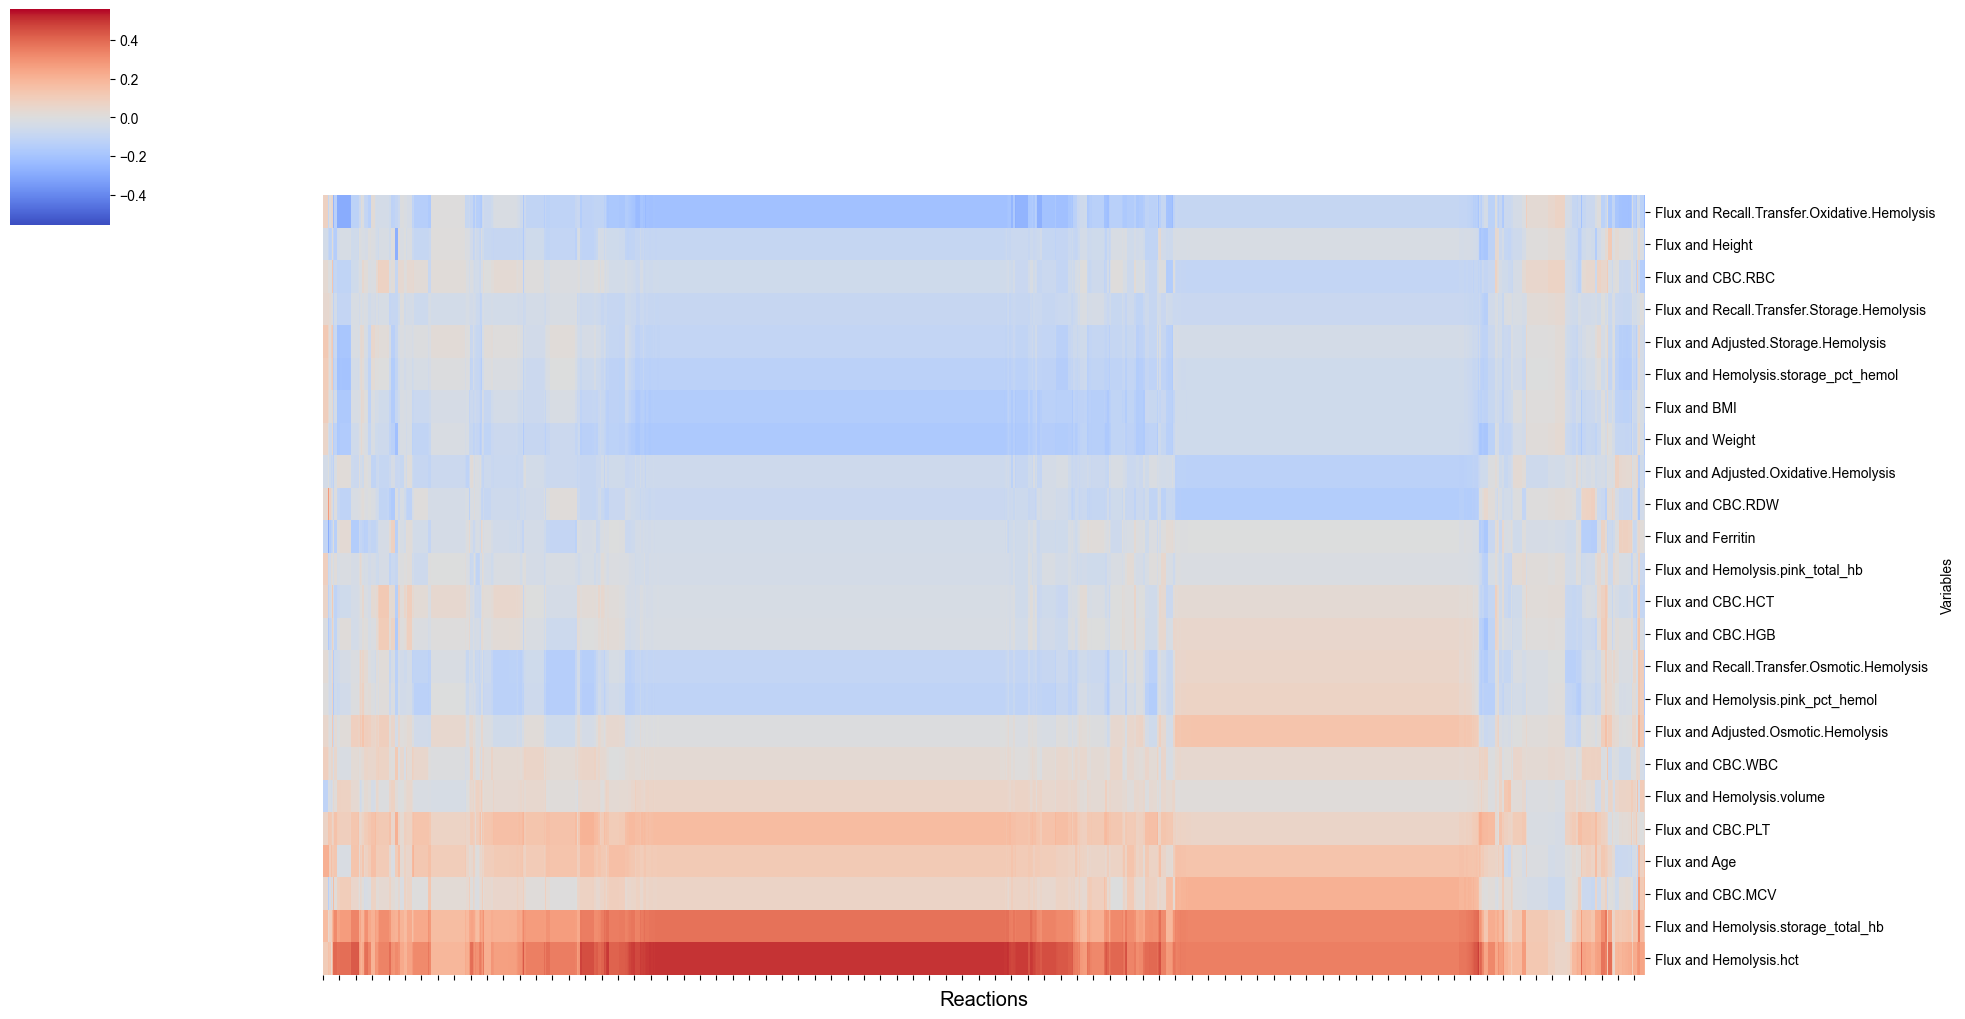

In [26]:
dtype = "Flux"
df_dtype = df_all_correlations.dropna().copy()
if "Flux and Expression" in df_dtype.columns:
    df_dtype = df_dtype.drop("Flux and Expression", level=0, axis=1)
df_dtype = df_dtype.loc[
    :, [x for x in df_dtype.columns if x[0].startswith(dtype) or x[0] in cat_cols]
]
df_dtype.to_csv(
    f"{dataset_path}/{pcmodel.id}_{dataset_name}_METADATA_{dtype.upper()}_CORRELATIONS.tsv",
    sep="\t",
    index=True,
)
df_dtype = df_dtype.loc[
    :, [x for x in df_dtype.columns if x[1] == "rho" or x[0] in cat_cols]
].droplevel(1, axis=1)
df_dtype

df_data = df_dtype.droplevel(1, axis=0)
df_data = df_data.loc[
    sorted(
        df_data.index,
        key=lambda x: (mapping_dict[model.reactions.get_by_id(x).subsystem], x),
    )
].T
df_data = df_data.loc[~df_data.index.isin(cat_cols)].astype(float)

# Cant exceed absolute value of 1
rho_lim = min(df_data.abs().max().max() * 1.1, 1)
fig = sns.clustermap(
    df_data,
    figsize=(20, 0.5 * len(df_data.index)),
    cmap="coolwarm",
    row_cluster=row_cluster,
    col_cluster=col_cluster,
    vmin=-rho_lim,
    vmax=rho_lim,
    row_linkage=linkage(
        df_data, method=row_method, metric=row_metric, optimal_ordering=optimal_ordering
    ),
    col_linkage=linkage(
        df_data.T,
        method=col_method,
        metric=col_metric,
        optimal_ordering=optimal_ordering,
    ),
    # col_colors=[category_colors[mapping_dict[model.reactions.get_by_id(x).subsystem]] for x in df_data.columns],
)
ax_heatmap = fig.ax_heatmap
ax_heatmap.set_xlabel("Reactions", fontsize="x-large")
ax_heatmap.xaxis.set_ticklabels([])
fig.ax_row_dendrogram.set_visible(False)
fig.ax_col_dendrogram.set_visible(False)
fig;

NameError: name 'figures_path' is not defined

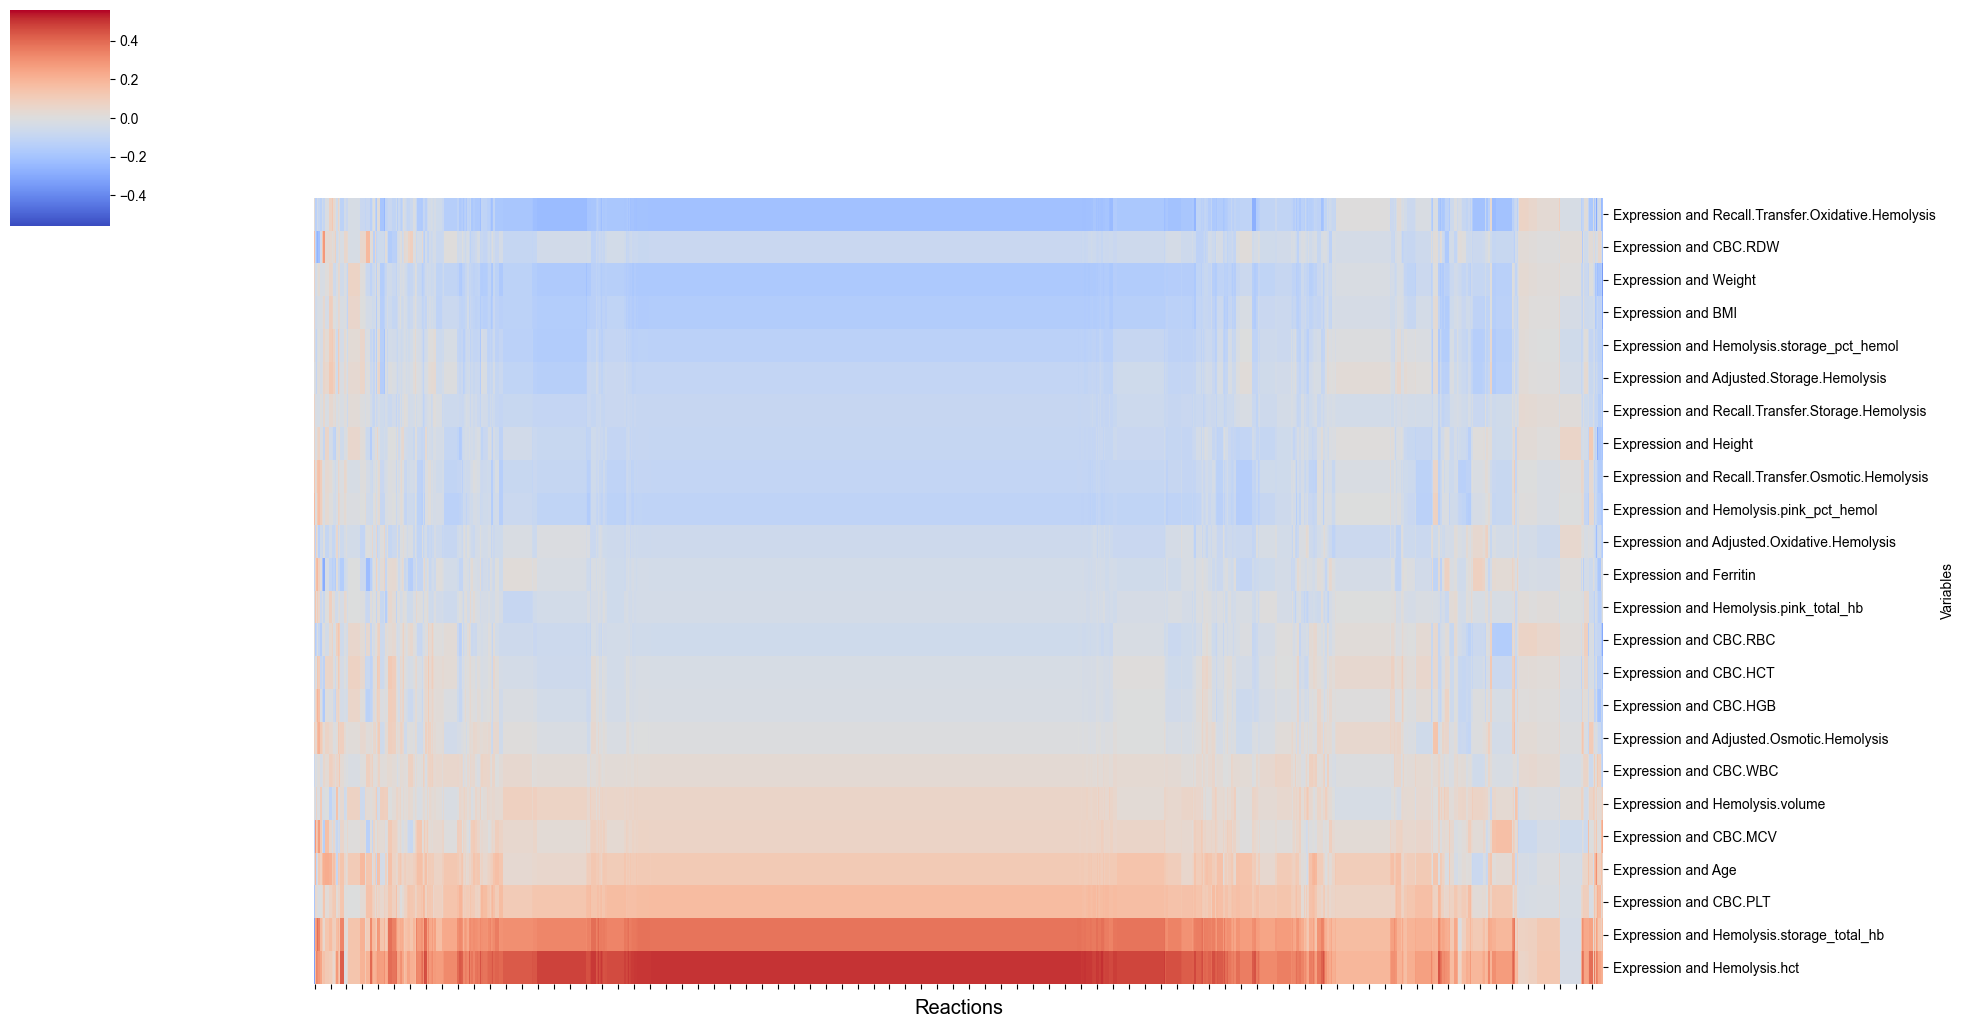

In [27]:
dtype = "Expr"
df_dtype = df_all_correlations.dropna().copy()
if "Flux and Expression" in df_dtype.columns:
    df_dtype = df_dtype.drop("Flux and Expression", level=0, axis=1)
df_dtype = df_dtype.loc[
    :, [x for x in df_dtype.columns if x[0].startswith(dtype) or x[0] in cat_cols]
]
df_dtype.to_csv(
    f"{dataset_path}/{pcmodel.id}_{dataset_name}_METADATA_{dtype.upper()}_CORRELATIONS.tsv",
    sep="\t",
    index=True,
)
df_dtype = df_dtype.loc[
    :, [x for x in df_dtype.columns if x[1] == "rho" or x[0] in cat_cols]
].droplevel(1, axis=1)
df_dtype

df_data = df_dtype.droplevel(1, axis=0)
df_data = df_data.loc[
    sorted(
        df_data.index,
        key=lambda x: (mapping_dict[model.reactions.get_by_id(x).subsystem], x),
    )
].T
df_data = df_data.loc[~df_data.index.isin(cat_cols)].astype(float)

# Cant exceed absolute value of 1
rho_lim = min(df_data.abs().max().max() * 1.1, 1)
fig = sns.clustermap(
    df_data,
    figsize=(20, 0.5 * len(df_data.index)),
    cmap="coolwarm",
    row_cluster=row_cluster,
    col_cluster=col_cluster,
    vmin=-rho_lim,
    vmax=rho_lim,
    row_linkage=linkage(
        df_data, method=row_method, metric=row_metric, optimal_ordering=optimal_ordering
    ),
    col_linkage=linkage(
        df_data.T,
        method=col_method,
        metric=col_metric,
        optimal_ordering=optimal_ordering,
    ),
    # col_colors=[category_colors[mapping_dict[model.reactions.get_by_id(x).subsystem]] for x in df_data.columns],
)
ax_heatmap = fig.ax_heatmap
ax_heatmap.set_xlabel("Reactions", fontsize="x-large")
ax_heatmap.xaxis.set_ticklabels([])
ax_heatmap.xaxis.set_tick_params(labelsize="x-large")
fig.ax_row_dendrogram.set_visible(False)
fig.ax_col_dendrogram.set_visible(False)

if save_figures:
    fig.savefig(
        f"{figures_path}/Fig6_PanelB_{dtype}MetaDataCorr_{model.id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

#### Visualize correlations with metadata

In [ ]:
# Consistent plot dimensions and values
pvalue_tol = 1e-320
scatter_inch = 5  # Length x width of scatter plot
hist_inch = 1  # Length or width of histogram addition
hist_pad = 0.4  # Space between scatter and histogram
cmap = "viridis"
edgecolor = "black"
edgewidth = 0.5
grid = False
zorder = 2
histx = True
histy = True

##### Age

In [ ]:
metadata_col = "Age"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)

print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### BMI

In [ ]:
metadata_col = "BMI"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Weight

In [ ]:
metadata_col = "Weight"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=30,
    ytick_minor=10,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Height

In [ ]:
metadata_col = "Height"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Hemolysis.volume

In [ ]:
metadata_col = "Hemolysis.volume"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Hemolysis.hct

In [ ]:
metadata_col = "Hemolysis.hct"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=30,
    ytick_minor=10,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)

axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Hemolysis.storage_total_hb

In [ ]:
metadata_col = "Hemolysis.storage_total_hb"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=30,
    ytick_minor=10,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Hemolysis.storage_pct_hemol

In [ ]:
metadata_col = "Hemolysis.storage_pct_hemol"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Hemolysis.pink_total_hb

In [ ]:
metadata_col = "Hemolysis.pink_total_hb"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Hemolysis.pink_pct_hemol

In [ ]:
metadata_col = "Hemolysis.pink_pct_hemol"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Recall.Transfer.Storage.Hemolysis

In [ ]:
metadata_col = "Recall.Transfer.Storage.Hemolysis"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Recall.Transfer.Osmotic.Hemolysis

In [ ]:
metadata_col = "Recall.Transfer.Osmotic.Hemolysis"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Recall.Transfer.Oxidative.Hemolysis

In [ ]:
metadata_col = "Recall.Transfer.Oxidative.Hemolysis"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Adjusted.Storage.Hemolysis

In [ ]:
metadata_col = "Adjusted.Storage.Hemolysis"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Adjusted.Osmotic.Hemolysis

In [ ]:
metadata_col = "Adjusted.Osmotic.Hemolysis"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Adjusted.Oxidative.Hemolysis

In [ ]:
metadata_col = "Adjusted.Oxidative.Hemolysis"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### CBC.WBC

In [ ]:
metadata_col = "CBC.WBC"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### CBC.RBC

In [ ]:
metadata_col = "CBC.RBC"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### CBC.HGB

In [ ]:
metadata_col = "CBC.HGB"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=800,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=1,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=800,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### CBC.HCT

In [ ]:
metadata_col = "CBC.HCT"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)

if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### CBC.MCV

In [ ]:
metadata_col = "CBC.MCV"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### CBC.RDW

In [ ]:
metadata_col = "CBC.RDW"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### CBC.PLT

In [ ]:
metadata_col = "CBC.PLT"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;

##### Ferritin

In [ ]:
metadata_col = "Ferritin"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_expr) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Expression", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_expr = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_expr["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_expr = plot_correlations(
    df_corr_expr,
    ax=ax_expr,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_expr.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Expression and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_expr[0].set_title(
    f"Expression and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_expr[1])
axes_flux[2].sharex(axes_expr[2])
fig;